In [1]:
import numpy as np
import tqdm 
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys

sys.path.append('../my_funcs/')
from pipeline_main import pipeline, dist

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

# Reynold stress
### The mechanical flux of angular momentum is associated with the Reynolds stress $\rho v \otimes v$
## $\otimes$: Dyadic product
#### An important aspect in protoplanetary disk studies is how the angular momentum is transported from the environment to the star–disk system. To study the flow of angular momentum, we consider a cylindrical test volume with the height equal to the diameter (h = 2R) and calculate the angular momentum flux through the cylinder wall (the “radial direction”) and through the top and bottom of the cylinder (the “vertical Figure 9. Evolution of the α angle for four spheres of radii 50, 100, 300, and 1000 au. The symbols belong to the same sinks as in Figure 5. Figure 10. Slices in the plane vertical to the mean angular momentum vector calculated for a sphere of 100 au at t=50 kyr. First row: sink 1 (left), sink 4 (right); second row: sink 5 (left), sink 6 (right); third row: sink 7 (left), sink 9 (right). 8 The Astrophysical Journal, 846:7 (21pp), 2017 September 1 Kuffmeier, Haugbølle, & Nordlund direction”).

### Radial direction:
#### $$F_r^v(R)=\int_{-h/2}^{h/2}dz \int_0^{2\pi}R^2d\phi \rho v_\phi(R,\phi,z)v_r(R,\phi,z)$$


## In the $\phi$-average plots i make a mass weighted average for each 2d histrogram cell

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1232.92it/s]


Converged mean angular momentum vector after 1 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 9074.40it/s] 


Disk size: 17.9 au


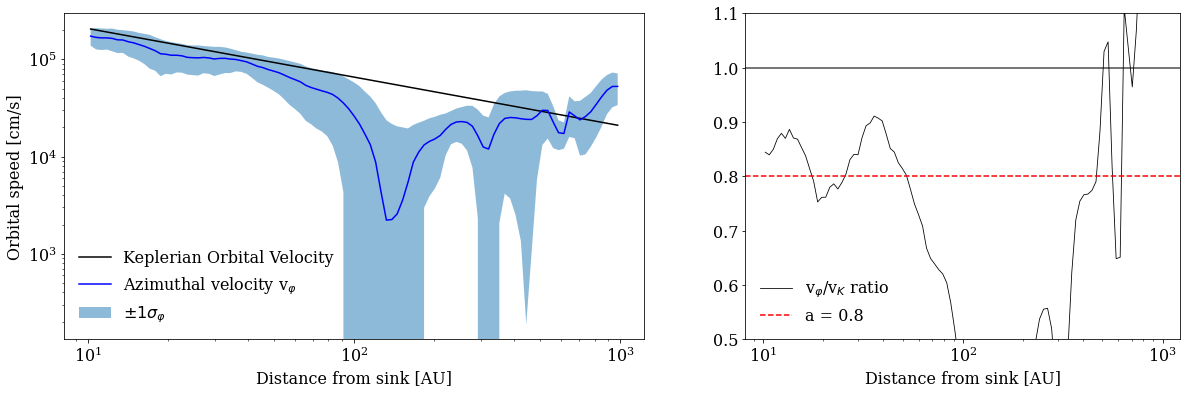

In [2]:
data = pipeline(snap = 357, run = 'my_core_13lacc')
data.recalc_L(verbose = 1); 
data.calc_disksize()

# Average cell size as a function of radius

In [46]:
selection_radius = 10000 / data.au_length
pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]

cell_dist = []
cell_size = []

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

extracted_values =  {key: [] for key in range(5)} # So far this is only for densities and velocities

for p in sorted_patches:
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    to_extract = np.linalg.norm(p.rel_xyz, axis = 0) < selection_radius
    
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool 

    R = p.cyl_R[to_extract].T
    
    cell_dist.extend(R.tolist())
    cell_size.extend(p.ds[0] * np.ones(len(R)))

cell_dist = np.asarray(cell_dist) * data.au_length
cell_size = np.asarray(cell_size)* data.au_length

[Text(0.5, 0, 'Distance from sink [au]'), Text(0, 0.5, 'Cell size [au]')]

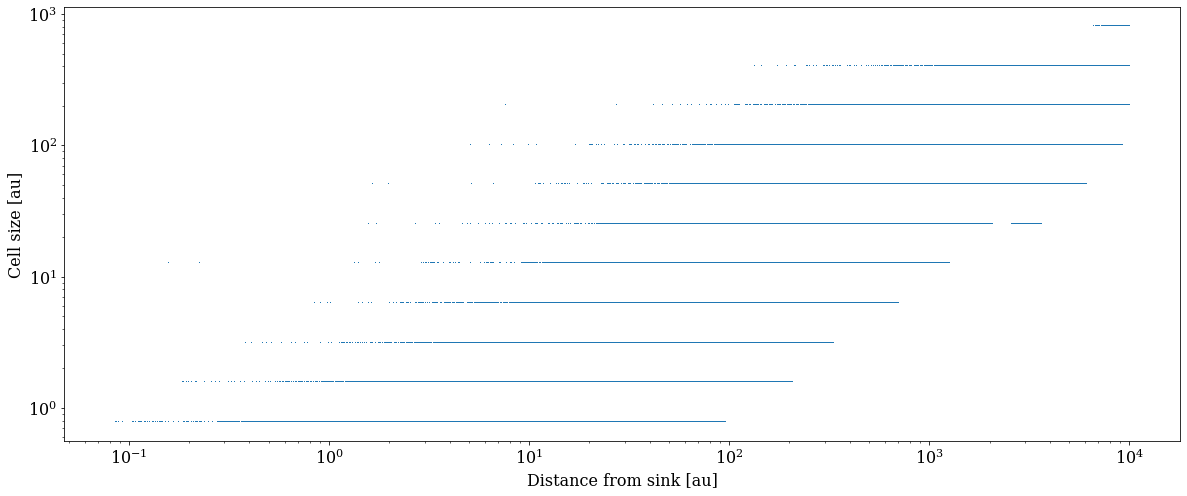

In [48]:
idx_sort = np.argsort(cell_dist)

fig, axs = plt.subplots(figsize = (20, 8))
axs.loglog(cell_dist[idx_sort] , cell_size[idx_sort],',')

axs.set(xlabel = 'Distance from sink [au]', ylabel = 'Cell size [au]')

In [5]:
radius = 40
height = radius / 2
Nh = 100
radius /= data.au_length; height /= data.au_length
selection_radius = np.sqrt(radius**2 + height**2) * 1.5 
shell_Δ = 1; shell_Δ /= data.au_length

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

extracted_values =  {key: [] for key in range(5)} # So far this is only for densities and velocities

for p in sorted_patches:
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    to_extract = (p.cyl_R < radius - shell_Δ) & (p.cyl_R <  radius + shell_Δ)
    p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
    p.vr = np.sum(p.vrel * p.e_r, axis = 0)
    
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool 
    
    vel_r = p.vr[to_extract].T
    vel_φ = p.vφ[to_extract].T
    z_coor = p.cyl_z[to_extract].T 
    R_coor = p.cyl_R[to_extract].T
    mass_val = p.m[to_extract].T
       
    #extracted_values[0].extend(R_coor.tolist())
    extracted_values[0].extend(z_coor.tolist())
    extracted_values[1].extend(vel_r.tolist())
    extracted_values[2].extend(vel_φ.tolist())
    extracted_values[3].extend(mass_val.tolist())
    extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))

for key in extracted_values:
    extracted_values[key] = np.array(extracted_values[key])

z_grid = np.linspace(-radius, radius, Nh)
hist_mass, binedges = np.histogram(extracted_values[0], bins = z_grid, weights = extracted_values[3])
hist_vol, _ = np.histogram(extracted_values[0], bins = z_grid, weights = extracted_values[4])
hist_ρ = hist_mass/hist_vol

hist_vφ = np.histogram(extracted_values[0], bins = z_grid, weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
hist_vr = np.histogram(extracted_values[0], bins = z_grid, weights = extracted_values[1] * extracted_values[3])[0] / hist_mass 

z_bins = z_grid[:-1] + 0.5 * np.diff(binedges)

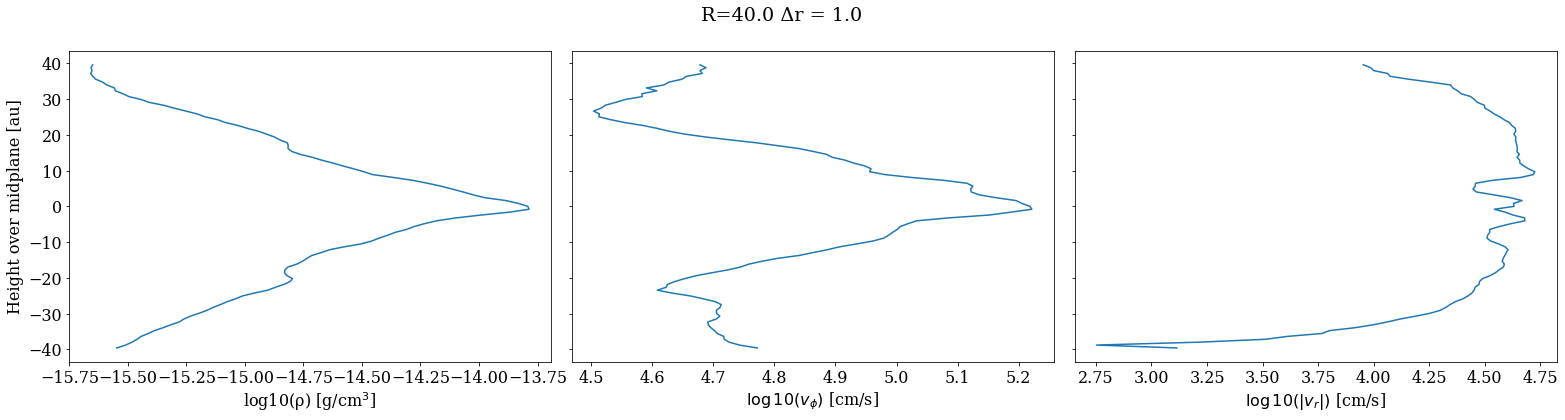

In [9]:
fig, axs = plt.subplots(1,3, figsize = (22,6), sharey=True)

ax = axs[0]
ax.plot(np.log10(hist_ρ * data.cgs_density), z_bins * data.au_length)
ax.set(ylabel = 'Height over midplane [au]', xlabel = 'log10(ρ) [g/cm$^3$]')

ax = axs[1]
ax.plot((np.log10(hist_vφ * data.cms_velocity)), z_bins * data.au_length)
ax.set(xlabel = '$\log10(v_\phi)$ [cm/s]')

ax = axs[2]
ax.plot((np.log10((abs(hist_vr) * data.cms_velocity))), z_bins * data.au_length)
ax.set(xlabel = '$\log10(|v_r|)$ [cm/s]')

fig.suptitle(f'R={radius * data.au_length} Δr = {shell_Δ * data.au_length}')
fig.tight_layout()


## How do I work with $d\phi$ and multiply this into when all the original data is scattered over all angles?

## Dimension: [$ml^2t^{-2}$]

3.169150224058921e-11

In [41]:
np.sum(hist_vφ * hist_vr * data.cms_velocity**2 * hist_ρ * data.cgs_density * radius * np.diff(z_grid)[0] * data.sn.scaling.l**2) / 10 * (1000 * data.sn.cgs.yr)**(-1)

-27696103577125.906

### Vectical direction:
#### $$F_v^v(R)=\pm\int_{0}^{R}dr \int_0^{2\pi}r d\phi r \rho\;v_\phi(R,\phi,\pm h/2)\times v_r(R,\phi,\pm h/2)$$

#### Since $v_\phi$ and $v_r$ are perpendicular the cross product must just be $|v_\phi||v_r|$
### Should it be bined accordingly to $\phi$?

In [ ]:
radius = 40
height = radius / 2
Nh = 100
radius /= data.au_length; height /= data.au_length
selection_radius = np.sqrt(radius**2 + height**2) * 1.5 
shell_Δ = 1; shell_Δ /= data.au_length

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

extracted_values =  {key: [] for key in range(5)} # So far this is only for densities and velocities

for p in sorted_patches:
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    to_extract = (p.cyl_R < radius - shell_Δ) & (p.cyl_R <  radius + shell_Δ)
    p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
    p.vr = np.sum(p.vrel * p.e_r, axis = 0)
    
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool 
    
    vel_r = p.vr[to_extract].T
    vel_φ = p.vφ[to_extract].T
    z_coor = p.cyl_z[to_extract].T 
    R_coor = p.cyl_R[to_extract].T
    mass_val = p.m[to_extract].T
       
    #extracted_values[0].extend(R_coor.tolist())
    extracted_values[0].extend(z_coor.tolist())
    extracted_values[1].extend(vel_r.tolist())
    extracted_values[2].extend(vel_φ.tolist())
    extracted_values[3].extend(mass_val.tolist())
    extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))

for key in extracted_values:
    extracted_values[key] = np.array(extracted_values[key])

z_grid = np.linspace(-radius, radius, Nh)
hist_mass, binedges = np.histogram(extracted_values[0], bins = z_grid, weights = extracted_values[3])
hist_vol, _ = np.histogram(extracted_values[0], bins = z_grid, weights = extracted_values[4])
hist_ρ = hist_mass/hist_vol

hist_vφ = np.histogram(extracted_values[0], bins = z_grid, weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
hist_vr = np.histogram(extracted_values[0], bins = z_grid, weights = extracted_values[1] * extracted_values[3])[0] / hist_mass 

z_bins = z_grid[:-1] + 0.5 * np.diff(binedges)